# Tier 2. Module 4 - Deep Learning. Homeworkes

## Lessons 11-12: Text as a sequence. The mechanism of attention

The task is to develop a machine translation model using the [Helsinki-NLP/europarl](https://huggingface.co/datasets/Helsinki-NLP/europarl) dataset. This dataset is a parallel corpus extracted from the European Parliament website and is intended for research in the field of statistical machine translation.

Technical task:

1. Select a language pair from the Helsinki-NLP/europarl dataset for which you will develop a translation model. You are free to choose any language pair represented in this dataet.

2. Using the selected language pair, develop a deep learning model for machine translation. You can use architectures based on recurrent neural networks (RNN), seq2seq or other approaches that you consider appropiate.

3. Train the model on the selected subset of the data.
4. Analyze the loss function and attention mechanism:
* plot the loss function change during training and analyze it,
* visualize the attention mechanism for several translation examples,
* draw conclusions about how the attention mechanism works in the developed model.

### 1. Import of the required libraries

In [1]:
! python3 -m spacy download en
! python3 -m spacy download it

⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 93.3 MB/s eta 0:00:0000:010:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ As of spaCy v3.0, shortcuts like 'it' are deprecated. Please use the
full pipeline package name 'it_core_news_sm' instead.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 91.2 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('it_core_news_sm')


In [2]:
!pip install update torch==2.0.1
!pip install torchtext==0.15.2
!pip install datasets==2.14.7
!pip install evaluate==0.4.0
!pip install torchvision==0.15.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 2.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 94.0 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 76.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 10.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 31.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 16.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 9.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.1/177.1 MB 9.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━

In [3]:
import os
import random
from tqdm.auto import tqdm
from dataclasses import dataclass

import pandas as pd
import numpy as np

import spacy
import en_core_web_sm
import it_core_news_sm

import datasets
import torchtext

import torch
import torch.nn as nn
import torch.optim as optim

import evaluate

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

Set random seed.

In [4]:
seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

### 2. Choosing a language pair

This task will be performed using the example of English and Italian languages.

### 3. Data loading and preparation

In [5]:
fraction = 5 # 100
dataset = datasets.load_dataset("Helsinki-NLP/europarl", "en-it", split=f"train[:{fraction}%]")
dataset

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1946253 [00:00<?, ? examples/s]

Dataset({
    features: ['translation'],
    num_rows: 97313
})

The dataset is in an impractical format, let's flatten it to simplify further processing.

In [6]:
def flatten_dataset(example):
    return {
        "en": example["translation"]["en"],
        "it": example["translation"]["it"]
    }

dataset = dataset.map(flatten_dataset, remove_columns=["translation"])
dataset

Map:   0%|          | 0/97313 [00:00<?, ? examples/s]

Dataset({
    features: ['en', 'it'],
    num_rows: 97313
})

Train, test and validation split.

In [7]:
dataset = dataset.train_test_split(test_size=0.2)
test_valid_split = dataset['test'].train_test_split(test_size=0.5)

train_data = dataset['train']
valid_data = test_valid_split['train']
test_data = test_valid_split['test']

print(len(train_data), len(valid_data), len(test_data))

77850 9731 9732


In [8]:
train_data[0]

{'en': 'Furthermore, however, atmospheric pollution has worsened as a result of acid rain, and of greater concentrations of dangerous products in the atmosphere.',
 'it': "Oltretutto, ultimamente l'inquinamento atmosferico è peggiorato a causa delle piogge acide e delle maggiori concentrazioni di sostanze pericolose nell'atmosfera."}

In [9]:
with pd.option_context('display.max_colwidth', None):
    example_df = pd.DataFrame(train_data[:5])
    display(example_df)

,en,it
0,"Furthermore, however, atmospheric pollution has worsened as a result of acid rain, and of greater concentrations of dangerous products in the atmosphere.","Oltretutto, ultimamente l'inquinamento atmosferico è peggiorato a causa delle piogge acide e delle maggiori concentrazioni di sostanze pericolose nell'atmosfera."
1,"Measures are needed against violence and racism in sport, in order to guarantee that sportsmen and women and sports fans are protected against rampaging hordes of hooligans and racists.","Si deve intervenire contro le violenze ed il razzismo nello sport, per proteggere gli atleti e gli sportivi dalle orde selvagge di teppisti e razzisti."
2,"The WWF reports that, according to Italian, French and Spanish customs authorities, illegal bluefin fishing and landings of small fish are on the increase.","Le relazioni del WWF segnalano che, secondo le autorità doganali italiane, francesi e spagnole, sono in aumento le catture illegali di tonno rosso e gli sbarchi di pesce di piccole dimensioni."
3,"They are causing Europe to lag behind America, and this to me is a serious issue, this process that works against an eEurope.",Per me si tratta di un fatto per nulla secondario nonchè di un' operazione di segno opposto alla eEurope.
4,"Mr President, Commissioner, with regard to end-of-life vehicles, we have reached a sound compromise.","Signor Presidente, signora Commissario, sul tema dei veicoli fuori uso abbiamo raggiunto un buon compromesso."


Tokenization of input data.

In [10]:
en_nlp = en_core_web_sm.load()
it_nlp = it_core_news_sm.load()

In [11]:
def tokenize_example(    
    example,
    en_nlp,
    it_nlp,
    max_length,
    lower,
    sos_token,
    eos_token
):
    '''
    Tokenizes a textual English-German input pair.    
    Args:
        example: (dict) a dictionary with one phrase in English and German; keys 'en', 'de'
        en_nlp: (spacy.lang) a spacy language model for English
        it_nlp: (spacy.lang) a spacy language model for Italian
        max_length: (int) max input sentence length, symbols
        lower: (bool) if to lowercase input
        sos_token: (str) a start_of_sequence token
        eos_token: (str) an end_of_sequence token
    
    Return:    
        (dict) pre-processed and tokenized input sequence  
    '''
    en_tokens = [token.text for token in en_nlp.tokenizer(example["en"])][:max_length]
    it_tokens = [token.text for token in it_nlp.tokenizer(example["it"])][:max_length]
    if lower:
        en_tokens = [token.lower() for token in en_tokens]
        it_tokens = [token.lower() for token in it_tokens]
    en_tokens = [sos_token] + en_tokens + [eos_token]
    it_tokens = [sos_token] + it_tokens + [eos_token]
    return {"en_tokens": en_tokens, "it_tokens": it_tokens}

In [12]:
max_length = 1_000
lower = True
sos_token = "<sos>"
eos_token = "<eos>"

fn_kwargs = {
    "en_nlp": en_nlp, 
    "it_nlp": it_nlp, 
    "max_length": max_length,
    "lower": lower,
    "sos_token": sos_token,
    "eos_token": eos_token,
}

train_data = train_data.map(tokenize_example, fn_kwargs=fn_kwargs)
valid_data = valid_data.map(tokenize_example, fn_kwargs=fn_kwargs)
test_data = test_data.map(tokenize_example, fn_kwargs=fn_kwargs)

Map:   0%|          | 0/77850 [00:00<?, ? examples/s]

Map:   0%|          | 0/9731 [00:00<?, ? examples/s]

Map:   0%|          | 0/9732 [00:00<?, ? examples/s]

In [13]:
train_data[0]

{'en': 'Furthermore, however, atmospheric pollution has worsened as a result of acid rain, and of greater concentrations of dangerous products in the atmosphere.',
 'it': "Oltretutto, ultimamente l'inquinamento atmosferico è peggiorato a causa delle piogge acide e delle maggiori concentrazioni di sostanze pericolose nell'atmosfera.",
 'en_tokens': ['<sos>',
  'furthermore',
  ',',
  'however',
  ',',
  'atmospheric',
  'pollution',
  'has',
  'worsened',
  'as',
  'a',
  'result',
  'of',
  'acid',
  'rain',
  ',',
  'and',
  'of',
  'greater',
  'concentrations',
  'of',
  'dangerous',
  'products',
  'in',
  'the',
  'atmosphere',
  '.',
  '<eos>'],
 'it_tokens': ['<sos>',
  'oltretutto',
  ',',
  'ultimamente',
  "l'",
  'inquinamento',
  'atmosferico',
  'è',
  'peggiorato',
  'a',
  'causa',
  'delle',
  'piogge',
  'acide',
  'e',
  'delle',
  'maggiori',
  'concentrazioni',
  'di',
  'sostanze',
  'pericolose',
  "nell'",
  'atmosfera',
  '.',
  '<eos>']}

Creating a vocab.

In [14]:
min_freq = 2 # minimum frequency of occurrence in the text
unk_token = "<unk>" # unknown token
pad_token = "<pad>" # padding token

special_tokens = [
    unk_token,
    pad_token,
    sos_token,
    eos_token,
]

en_vocab = torchtext.vocab.build_vocab_from_iterator(
    train_data["en_tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)

it_vocab = torchtext.vocab.build_vocab_from_iterator(
    train_data["it_tokens"],
    min_freq=min_freq,
    specials=special_tokens,  
)

In [15]:
assert en_vocab[unk_token] == it_vocab[unk_token]
assert en_vocab[pad_token] == it_vocab[pad_token]

unk_index = en_vocab[unk_token]
pad_index = en_vocab[pad_token]

print(unk_index)
print(pad_index)

print(en_vocab['the'])

0
1
4


Setting default value for OOV words.

In [16]:
en_vocab.set_default_index(unk_index)
it_vocab.set_default_index(unk_index)

In [17]:
def numericalize_example(example, en_vocab, it_vocab):
    '''
    Creates a mapping from string tokens to the vocabulary indexes.
    '''
    en_ids = en_vocab.lookup_indices(example["en_tokens"])
    it_ids = it_vocab.lookup_indices(example["it_tokens"])
    return {"en_ids": en_ids, "it_ids": it_ids}

In [18]:
fn_kwargs = {
    "en_vocab": en_vocab, 
    "it_vocab": it_vocab
}

train_data = train_data.map(numericalize_example, fn_kwargs=fn_kwargs)
valid_data = valid_data.map(numericalize_example, fn_kwargs=fn_kwargs)
test_data = test_data.map(numericalize_example, fn_kwargs=fn_kwargs)

Map:   0%|          | 0/77850 [00:00<?, ? examples/s]

Map:   0%|          | 0/9731 [00:00<?, ? examples/s]

Map:   0%|          | 0/9732 [00:00<?, ? examples/s]

In [19]:
train_data[0]

{'en': 'Furthermore, however, atmospheric pollution has worsened as a result of acid rain, and of greater concentrations of dangerous products in the atmosphere.',
 'it': "Oltretutto, ultimamente l'inquinamento atmosferico è peggiorato a causa delle piogge acide e delle maggiori concentrazioni di sostanze pericolose nell'atmosfera.",
 'en_tokens': ['<sos>',
  'furthermore',
  ',',
  'however',
  ',',
  'atmospheric',
  'pollution',
  'has',
  'worsened',
  'as',
  'a',
  'result',
  'of',
  'acid',
  'rain',
  ',',
  'and',
  'of',
  'greater',
  'concentrations',
  'of',
  'dangerous',
  'products',
  'in',
  'the',
  'atmosphere',
  '.',
  '<eos>'],
 'it_tokens': ['<sos>',
  'oltretutto',
  ',',
  'ultimamente',
  "l'",
  'inquinamento',
  'atmosferico',
  'è',
  'peggiorato',
  'a',
  'causa',
  'delle',
  'piogge',
  'acide',
  'e',
  'delle',
  'maggiori',
  'concentrazioni',
  'di',
  'sostanze',
  'pericolose',
  "nell'",
  'atmosfera',
  '.',
  '<eos>'],
 'en_ids': [2,
  674,
 

Data to torch Dataset format.

In [20]:
data_type = "torch"
format_columns = ["en_ids", "it_ids"]

train_data = train_data.with_format(
    type=data_type, 
    columns=format_columns, 
    output_all_columns=True
)

valid_data = valid_data.with_format(
    type=data_type, 
    columns=format_columns, 
    output_all_columns=True,
)

test_data = test_data.with_format(
    type=data_type, 
    columns=format_columns, 
    output_all_columns=True,
)

In [21]:
train_data

Dataset({
    features: ['en', 'it', 'en_tokens', 'it_tokens', 'en_ids', 'it_ids'],
    num_rows: 77850
})

In [22]:
train_data[0]

{'en_ids': tensor([    2,   674,     5,   106,     5,  5256,   908,    31, 12352,    25,
            12,   348,     7,  9424,  7134,     5,     9,     7,   397,  5552,
             7,   963,   440,    10,     4,  3177,     6,     3]),
 'it_ids': tensor([    2,  7631,     4, 10909,    26,   979,  5563,    16, 24699,    14,
           397,    29, 14890, 15464,     8,    29,  1033,  4067,     5,   954,
          1812,   177,  3529,     6,     3]),
 'en': 'Furthermore, however, atmospheric pollution has worsened as a result of acid rain, and of greater concentrations of dangerous products in the atmosphere.',
 'it': "Oltretutto, ultimamente l'inquinamento atmosferico è peggiorato a causa delle piogge acide e delle maggiori concentrazioni di sostanze pericolose nell'atmosfera.",
 'en_tokens': ['<sos>',
  'furthermore',
  ',',
  'however',
  ',',
  'atmospheric',
  'pollution',
  'has',
  'worsened',
  'as',
  'a',
  'result',
  'of',
  'acid',
  'rain',
  ',',
  'and',
  'of',
  'greater',


Creating dataloaders and adding padding.

In [23]:
def get_collate_fn(pad_index):
    '''
    Adding padding as a part of a collate_fn.
    '''
    
    def collate_fn(batch):
        batch_en_ids = [example["en_ids"] for example in batch]
        batch_it_ids = [example["it_ids"] for example in batch]
        batch_en_ids = nn.utils.rnn.pad_sequence(batch_en_ids, padding_value=pad_index)
        batch_it_ids = nn.utils.rnn.pad_sequence(batch_it_ids, padding_value=pad_index)
        batch = {
            "en_ids": batch_en_ids,
            "it_ids": batch_it_ids,
        }
        return batch
    
    return collate_fn

In [24]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    
    collate_fn = get_collate_fn(pad_index)
    
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    
    return data_loader

In [25]:
batch_size = 32 # 128

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

In [26]:
torchtext.__version__

'0.15.2+cpu'

Check iteration over one batch.

In [27]:
next(iter(train_data_loader))

{'en_ids': tensor([[   2,    2,    2,  ...,    2,    2,    2],
         [  33,   69,  722,  ...,   17,   14,    4],
         [4801,   15,  136,  ...,  524,   11,  894],
         ...,
         [   1,    1,    1,  ...,    1,    1,    1],
         [   1,    1,    1,  ...,    1,    1,    1],
         [   1,    1,    1,  ...,    1,    1,    1]]),
 'it_ids': tensor([[   2,    2,    2,  ...,    2,    2,    2],
         [  23,  175,    8,  ..., 2936,   34,    9],
         [ 105,  222,   18,  ..., 1533,   16,  250],
         ...,
         [   1,    1,    1,  ...,    1,    1,    1],
         [   1,    1,    1,  ...,    1,    1,    1],
         [   1,    1,    1,  ...,    1,    1,    1]])}

All sequences have the same length, and shorter sequences are extended using `<pad>`, i.e. its numerical representation is 1.

### 4. Model construction

Seq2Seq model

In [28]:
class Encoder(nn.Module):
    def __init__(self, input_dim, embedding_dim, encoder_hidden_dim, decoder_hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.GRU(embedding_dim, encoder_hidden_dim, bidirectional = True)
        self.fc = nn.Linear(encoder_hidden_dim * 2, decoder_hidden_dim)
        
    def forward(self, src): # (src_length, batch size)
        embedded = self.embedding(src) # (src_length, batch_size, embedding_dim)

        outputs, hidden = self.rnn(embedded)
        # outputs (src_length, batch_size, hidden dim * n_directions)
        # hidden (n_layers * n_directions, batch_size, hidden dim)
        
        # hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        
        # outputs are always from the last layer
        # hidden [-2, :, : ] is the last of the forwards RNN 
        # hidden [-1, :, : ] is the last of the backwards RNN
       
        # initial decoder hidden is final hidden state of the forwards and backwards 
        # encoder RNNs fed through a linear layer
        
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)))
        
        # outputs (src_length, batch_size, encoder_hidden_dim * 2)
        # hidden (batch_size, decoder_hidden_dim)
        
        return outputs, hidden

In [29]:
class Attention(nn.Module):
    def __init__(self, encoder_hidden_dim, decoder_hidden_dim):
        super().__init__()
        self.attn_fc = nn.Linear(
            (encoder_hidden_dim * 2) + decoder_hidden_dim, 
            decoder_hidden_dim
        )
        self.v_fc = nn.Linear(decoder_hidden_dim, 1, bias=False)
        
    def forward(self, hidden, encoder_outputs):        
        # hidden (batch_size, decoder_hidden_dim)
        # encoder_outputs (src_length, batch_size, encoder_hidden dim * 2)
        
        batch_size = encoder_outputs.shape[1]
        src_length = encoder_outputs.shape[0]
        
        # repeat decoder hidden state src_length times
        hidden = hidden.unsqueeze(1).repeat(1, src_length, 1) # (batch_size, src_length, decoder_hidden_dim)
        encoder_outputs = encoder_outputs.permute(1, 0, 2) # (batch_size, src_length, encoder_hidden_dim * 2)
        
        energy = torch.tanh(self.attn_fc(torch.cat((hidden, encoder_outputs), dim=2))) 
        # (batch_size, src_length, decoder_hidden_dim)

        attention = self.v_fc(energy).squeeze(2) # batch_size, src_length

        return torch.softmax(attention, dim=1)

In [30]:
class Decoder(nn.Module):
    def __init__(
        self,
        output_dim,
        embedding_dim,
        encoder_hidden_dim,
        decoder_hidden_dim,
        attention,
    ):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, embedding_dim)
        self.rnn = nn.GRU((encoder_hidden_dim * 2) + embedding_dim, decoder_hidden_dim) 
        self.fc_out = nn.Linear(
            (encoder_hidden_dim * 2) + decoder_hidden_dim + embedding_dim, 
            output_dim
        )
        
    def forward(self, input, hidden, encoder_outputs):
        # input = (batch_size)
        # hidden = batch_size, decoder hidden dim]
        # encoder_outputs = [src length, batch size, encoder hidden dim * 2]
        input = input.unsqueeze(0)
        # input = [1, batch size]
        embedded = self.embedding(input)
        #embedded = [1, batch size, embedding dim]
        a = self.attention(hidden, encoder_outputs)
        # a = [batch size, src length]
        a = a.unsqueeze(1)
        # a = [batch size, 1, src length]
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        # encoder_outputs = [batch size, src length, encoder hidden dim * 2]
        weighted = torch.bmm(a, encoder_outputs) # batch matrix-matrix product
        # weighted = [batch size, 1, encoder hidden dim * 2]
        weighted = weighted.permute(1, 0, 2)
        # weighted = [1, batch size, encoder hidden dim * 2]
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        # rnn_input = [1, batch size, (encoder hidden dim * 2) + embedding dim]
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        # output = [seq length, batch size, decoder hid dim * n directions]
        # hidden = [n layers * n directions, batch size, decoder hid dim]
        # seq len, n layers and n directions will always be 1 in this decoder, therefore:
        # output = [1, batch size, decoder hidden dim]
        # hidden = [1, batch size, decoder hidden dim]
        # this also means that output == hidden
        assert (output == hidden).all()
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim=1))
        #prediction = [batch size, output dim]
        return prediction, hidden.squeeze(0), a.squeeze(1)

In [31]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio):
        # src = [src length, batch size]
        # trg = [trg length, batch size]
        # teacher_forcing_ratio is probability to use teacher forcing
        # e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
        batch_size = src.shape[1]
        trg_length = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_length, batch_size, trg_vocab_size).to(self.device)
        # encoder_outputs is all hidden states of the input sequence, back and forwards
        # hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src)
        # outputs = [src length, batch size, encoder hidden dim * 2]
        # hidden = [batch size, decoder hidden dim]
        # first input to the decoder is the <sos> tokens
        input = trg[0,:]
        for t in range(1, trg_length):
            # insert input token embedding, previous hidden state and all encoder hidden states
            # receive output tensor (predictions) and new hidden state
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs)
            # output = [batch size, output dim]
            # hidden = [n layers, batch size, decoder hidden dim]
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            # if teacher forcing, use actual next token as next input
            # if not, use predicted token
            input = trg[t] if teacher_force else top1
            # input = [batch size]
        return outputs

In [32]:
input_dim = len(it_vocab)
output_dim = len(en_vocab)
encoder_embedding_dim = 256
decoder_embedding_dim = 256
encoder_hidden_dim = 512
decoder_hidden_dim = 512
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_dir = '/kaggle/working/'

In [33]:
attention = Attention(encoder_hidden_dim, decoder_hidden_dim)

encoder = Encoder(
    input_dim,
    encoder_embedding_dim,
    encoder_hidden_dim,
    decoder_hidden_dim
)

decoder = Decoder(
    output_dim,
    decoder_embedding_dim,
    encoder_hidden_dim,
    decoder_hidden_dim,
    attention,
)


seq_model = Seq2Seq(encoder, decoder, device).to(device)

seq_model

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(26686, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn_fc): Linear(in_features=1536, out_features=512, bias=True)
      (v_fc): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(17571, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=17571, bias=True)
  )
)

In [34]:
def init_weights(m):
    """
    Initiates model weights from the normal distribution.
    Sets bias to 0.
    """
    for name, param in m.named_parameters():
        if "weight" in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
seq_model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(26686, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn_fc): Linear(in_features=1536, out_features=512, bias=True)
      (v_fc): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(17571, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=17571, bias=True)
  )
)

### 5. Loss function and optimizer

In [35]:
seq_optimizer = optim.Adam(seq_model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=pad_index)

### 6. Model training

In [36]:
def train_fn(model, data_loader, optimizer, criterion, clip, teacher_forcing_ratio, device):
    model.train()
    epoch_loss = 0
    for i, batch in tqdm(enumerate(data_loader)):
        src = batch["it_ids"].to(device)
        trg = batch["en_ids"].to(device)
        # src = [src length, batch size]
        # trg = [trg length, batch size]
        optimizer.zero_grad()
        output = model(src, trg, teacher_forcing_ratio)
        # output = [trg length, batch size, trg vocab size]
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        # output = [(trg length - 1) * batch size, trg vocab size]
        trg = trg[1:].view(-1)
        # trg = [(trg length - 1) * batch size]
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(data_loader)

def evaluate_fn(model, data_loader, criterion, device):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            src = batch["it_ids"].to(device)
            trg = batch["en_ids"].to(device)
            # src = [src length, batch size]
            # trg = [trg length, batch size]
            output = model(src, trg, 0) #turn off teacher forcing
            # output = [trg length, batch size, trg vocab size]
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            # output = [(trg length - 1) * batch size, trg vocab size]
            trg = trg[1:].view(-1)
            # trg = [(trg length - 1) * batch size]
            loss = criterion(output, trg)
            epoch_loss += loss.item()
    return epoch_loss / len(data_loader)

In [37]:
n_epochs = 6
clip = 1.0 # gradient clipping
teacher_forcing_ratio = 0.5

best_valid_loss = float("inf")

tr_loss = []
val_loss = []

for epoch in tqdm(range(n_epochs)):
        
    train_loss = train_fn(
        seq_model, 
        train_data_loader, 
        seq_optimizer, 
        criterion, 
        clip, 
        teacher_forcing_ratio, 
        device,
    )
    
    valid_loss = evaluate_fn(
        seq_model, 
        valid_data_loader, 
        criterion, 
        device,
    )
    
    print(f"\tTrain Loss: {train_loss:7.3f}")
    print(f"\tValid Loss: {valid_loss:7.3f}")

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(seq_model.state_dict(), os.path.join(model_dir, 'en_it.pt'))
        print("Model saved")

    tr_loss.append(train_loss)
    val_loss.append(valid_loss)

  0%|          | 0/6 [00:00<?, ?it/s]

0it [00:00, ?it/s]

	Train Loss:   5.143
	Valid Loss:   5.410
Model saved


0it [00:00, ?it/s]

	Train Loss:   4.054
	Valid Loss:   5.250
Model saved


0it [00:00, ?it/s]

	Train Loss:   3.563
	Valid Loss:   5.273


0it [00:00, ?it/s]

	Train Loss:   3.234
	Valid Loss:   5.307


0it [00:00, ?it/s]

	Train Loss:   2.993
	Valid Loss:   5.427


0it [00:00, ?it/s]

	Train Loss:   2.827
	Valid Loss:   5.468


### 7. Results visualization

Loss function.

In [38]:
def print_metrics(train_metric, validation_metric, name):
    plt.figure(figsize=(4, 3))
    plt.plot(train_metric, label='Train')
    plt.plot(validation_metric, label='Validation')
    plt.legend(loc='best')
    plt.xlabel('Epochs')
    plt.ylabel(name)
    plt.title('Training vs Validation Metric')
    plt.show()

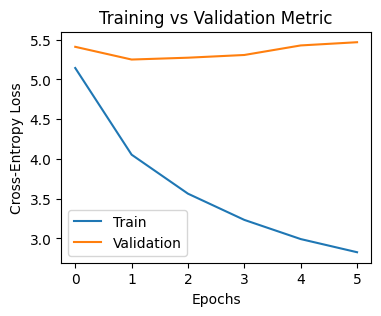

In [39]:
print_metrics(tr_loss, val_loss, "Cross-Entropy Loss")

In [40]:
seq_model.load_state_dict(torch.load(os.path.join(model_dir, 'en_it.pt'), map_location=device))

test_loss = evaluate_fn(seq_model, test_data_loader, criterion, device)

print(f"| Test Loss: {test_loss:.3f} | Test PPL: {np.exp(test_loss):7.3f} |")

| Test Loss: 5.249 | Test PPL: 190.456 |


### 8. Results validation

In [41]:
def translate_sentence(
    sentence, 
    model,
    en_nlp,
    it_nlp,
    en_vocab,
    it_vocab,
    lower,
    sos_token,
    eos_token,
    device,
    max_output_length=25,
):
    model.eval()
    with torch.no_grad():
        if isinstance(sentence, str):
            it_tokens = [token.text for token in it_nlp.tokenizer(sentence)]
        else:
            it_tokens = [token for token in sentence]
        if lower:
            it_tokens = [token.lower() for token in it_tokens]
        it_tokens = [sos_token] + it_tokens + [eos_token]
        ids = it_vocab.lookup_indices(it_tokens)
        tensor = torch.LongTensor(ids).unsqueeze(-1).to(device)
        
        encoder_outputs, hidden = model.encoder(tensor)
        
        inputs = en_vocab.lookup_indices([sos_token])
        
        attentions = torch.zeros(max_output_length, 1, len(ids))
        
        for i in range(max_output_length):
            inputs_tensor = torch.LongTensor([inputs[-1]]).to(device)
            output, hidden, attention = model.decoder(inputs_tensor, hidden, encoder_outputs)
            attentions[i] = attention
            predicted_token = output.argmax(-1).item()
            inputs.append(predicted_token)
            if predicted_token == en_vocab[eos_token]:
                break
        en_tokens = en_vocab.lookup_tokens(inputs)
    return en_tokens, it_tokens, attentions[:len(en_tokens)-1]

In [42]:
def plot_attention(sentence, translation, attention):
    fig, ax = plt.subplots(figsize=(5,5))
    attention = attention.squeeze(1).numpy()
    cax = ax.matshow(attention, cmap="bone")
    ax.set_xticks(ticks=np.arange(len(sentence)), labels=sentence, rotation=90, size=15)
    translation = translation[1:]
    ax.set_yticks(ticks=np.arange(len(translation)), labels=translation, size=15)
    plt.show()
    plt.close()

In [43]:
def plot_translation(index: int):
    sentence = test_data[index]["it"]
    expected_translation = test_data[index]["en"]
    
    translation, sentence_tokens, attention = translate_sentence(
        sentence,
        seq_model,
        en_nlp,
        it_nlp,
        en_vocab,
        it_vocab,
        lower,
        sos_token,
        eos_token,
        device,
    )
    print("Italian: ", sentence)
    print("English: ", expected_translation)
    print("Translation: ", " ".join(translation[1:]))

    return sentence_tokens, translation, attention

Let's check translation of one random sentence.

In [44]:
output_1 = plot_translation(1)

Italian:  Vorrei fare un'altra breve osservazione, poiché questa controversia ha rivelato l'esigenza di franche e tempestive discussioni sui molti punti in merito ai quali non vi è accordo.
English:  I want to make one other brief point, because this dispute highlights the need for earlier and more forthright discussions about the many issues over which there are disagreements.
Translation:  i would like to make a brief comment , because this has has the the has been the and and discussions on the many points


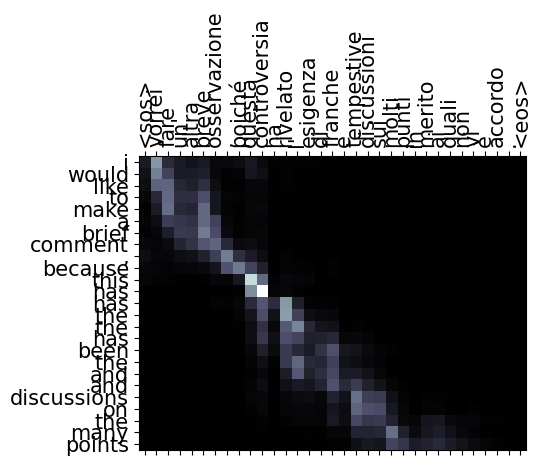

In [45]:
plot_attention(*output_1)

Let's check another sentence.

In [46]:
output_2 = plot_translation(10)

Italian:  Si attende il "brusco salto qualitativo" che farà passare, si spera, dal quantitativo al qualitativo a partire da una certa soglia.
English:  We are waiting for the 'critical qualitative mass' which, we hope, will change the quantitative into qualitative at a certain threshold.
Translation:  we are the the ' quality leap forward , will hopefully , , , , the quality of the quality of a high standard .


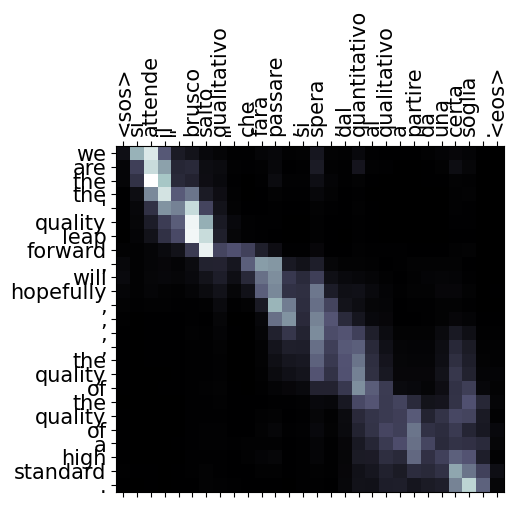

In [47]:
plot_attention(*output_2)

### 9. Analysis and interpretation

* From the analysis of the learning curves, we can conclude that the model began to overtrain already after the second epoch. Also, the validation and testing losses turned out to be quite high. This is due to the fact that due to limitations in computational resources, the model was trained on a rather small dataset, which includes less than 100 thousand translations from English to Italian (only 5% of the total dataset).* 
As can be seen from the translation examples made by the trained model, they are very far from satisfactory results, the model has great difficulties with articles and cuts the length of translated sentences
* 
From the analysis of the visualizations of the attention mechanism, we can conclude that the model has difficulties with comparisons of words in different languages, scattering the meaning of one word in the original language onto several words in the target language at once.